In [1]:
from gensim.models import KeyedVectors
import gensim.downloader as api

In [2]:
print("Loading model...")
model = api.load('word2vec-google-news-300')
print("Model loaded!")

Loading model...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Model loaded!


In [13]:
words = ['sports', 'university', 'food', 'money', 'technology']
print("Most similar word:")
for word in words:
    print(f"\nTop 5 words similar to '{word}':")
    similar_words = model.most_similar(word, topn=5)
    for sim_word, score in similar_words:
        print(f"  {sim_word} ({score:.4f})")

Most similar word:

Top 5 words similar to 'sports':
  sport (0.6915)
  sporting (0.6360)
  Sports (0.6295)
  DeVillers_reports (0.6123)
  athletics (0.6093)

Top 5 words similar to 'university':
  universities (0.7004)
  faculty (0.6781)
  unversity (0.6758)
  undergraduate (0.6587)
  univeristy (0.6585)

Top 5 words similar to 'food':
  foods (0.6805)
  Food (0.6539)
  foodstuffs (0.6426)
  meals (0.6167)
  food_stuffs (0.5929)

Top 5 words similar to 'money':
  monies (0.7165)
  funds (0.7055)
  moneys (0.6289)
  dollars (0.6289)
  cash (0.6151)

Top 5 words similar to 'technology':
  technologies (0.8332)
  innovations (0.6231)
  technological_innovations (0.6102)
  technol (0.6047)
  technological_advancement (0.6036)


In [14]:
print("Vector Arithmetic Examples:")

examples = [
    ("king", "man", "woman"),
    ("actor", "man", "woman"),
    ("uncle", "man", "woman"),
    ("father", "man", "woman"),
    ("paris", "france", "germany"),
    ("beijing", "china", "japan")
]

for a, b, c in examples:
    result = model.most_similar(positive=[a, c], negative=[b], topn=1)
    print(f"{a} - {b} + {c} ≈ {result[0][0]} ({result[0][1]:.4f})")

Vector Arithmetic Examples:
king - man + woman ≈ queen (0.7118)
actor - man + woman ≈ actress (0.8603)
uncle - man + woman ≈ aunt (0.8023)
father - man + woman ≈ mother (0.8463)
paris - france + germany ≈ berlin (0.4841)
beijing - china + japan ≈ tokyo (0.5117)


# Part 2

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [16]:
import pandas as pd
import os

df = pd.read_csv(os.path.join(path, "IMDB Dataset.csv"))
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


                                              review sentiment  review_len
0  One of the other reviewers has mentioned that ...  positive         307
1  A wonderful little production. <br /><br />The...  positive         162
2  I thought this was a wonderful way to spend ti...  positive         166
3  Basically there's a family where a little boy ...  negative         138
4  Petter Mattei's "Love in the Time of Money" is...  positive         230
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


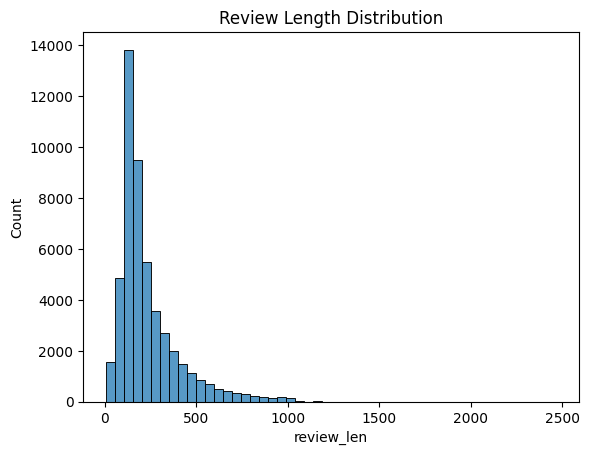

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

print(df.head())
print(df['sentiment'].value_counts())

df['review_len'] = df['review'].apply(lambda x: len(x.split()))
sns.histplot(df['review_len'], bins=50)
plt.title("Review Length Distribution")
plt.show()


In [22]:
import nltk
nltk.download('punkt', force=True)
nltk.download('stopwords', force=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"<.*?>", " ", text)                # remove HTML
    text = re.sub(r"[^a-zA-Z]", " ", text)            # remove punctuation/numbers
    words = word_tokenize(text.lower())
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return words

df['tokens'] = df['review'].apply(clean_text)
print(df[['review', 'tokens']].head())

                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                              tokens  
0  [one, reviewers, mentioned, watching, episode,...  
1  [wonderful, little, production, filming, techn...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, family, little, boy, jake, thinks,...  
4  [petter, mattei, love, time, money, visually, ...  


In [28]:
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import gensim.downloader as api

# Load model
w2v = api.load('word2vec-google-news-300')

# Average word vectors for a review
def avg_word_vector(tokens, model, vector_size=300):
    valid_tokens = [word for word in tokens if word in model]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean([model[word] for word in valid_tokens], axis=0)

X = np.array([avg_word_vector(tokens, w2v) for tokens in df['tokens']])
y = (df['sentiment'] == 'positive').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Pretrained W2V Performance:\n", classification_report(y_test, y_pred))


Pretrained W2V Performance:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [29]:
from gensim.models import Word2Vec, FastText

# Use tokenized corpus
corpus = df['tokens'].tolist()

# Skip-gram model
skipgram_model = Word2Vec(sentences=corpus, vector_size=100, window=5, sg=1, min_count=2)
cbow_model = Word2Vec(sentences=corpus, vector_size=100, window=5, sg=0, min_count=2)
fasttext_model = FastText(sentences=corpus, vector_size=100, window=5, min_count=2)

def get_model_results(model, name):
    X = np.array([avg_word_vector(tokens, model.wv, vector_size=100) for tokens in df['tokens']])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{name} Model Performance:\n", classification_report(y_test, y_pred))

get_model_results(skipgram_model, "Skip-gram")
get_model_results(cbow_model, "CBOW")
get_model_results(fasttext_model, "FastText")


Skip-gram Model Performance:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      4961
           1       0.88      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

CBOW Model Performance:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      4961
           1       0.86      0.87      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

FastText Model Performance:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      4961
           1       0.85      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85 